## Import Libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [4]:
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
df = pd.read_csv(url, names=column_names)

df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
df['class'].value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

## Data Preprocessing 

### Label Encoding of categorical features as they are ordinal

In [7]:
print(df['buying'].unique())
print(df['maint'].unique())
print(df['doors'].unique())
print(df['persons'].unique())
print(df['lug_boot'].unique())
print(df['safety'].unique())
print(df['class'].unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['2' '3' '4' '5more']
['2' '4' 'more']
['small' 'med' 'big']
['low' 'med' 'high']
['unacc' 'acc' 'vgood' 'good']


In [8]:
ordinal_mapping = {
    "buying": ["low", "med", "high", "vhigh"],
    "maint": ["low", "med", "high", "vhigh"],
    "lug_boot": ["small", "med", "big"],
    "safety": ["low", "med", "high"],
    "doors": ["2", "3", "4", "5more"],
    "persons": ["2", "4", "more"]
}

encoder = OrdinalEncoder(categories=[ordinal_mapping[col] for col in ordinal_mapping])
df_encoded = df.copy()
df_encoded[list(ordinal_mapping.keys())] = encoder.fit_transform(df[list(ordinal_mapping.keys())])

df_encoded[list(ordinal_mapping.keys())] = df_encoded[list(ordinal_mapping.keys())].astype(int)

label_encoder = LabelEncoder()
df_encoded["class"] = label_encoder.fit_transform(df["class"])

encoded_mappings = {}

for col in ordinal_mapping:
    encoded_mappings[col] = {category: idx for idx, category in enumerate(ordinal_mapping[col])}

encoded_mappings["class"] = {category: idx for idx, category in enumerate(label_encoder.classes_)}

for col, mapping in encoded_mappings.items():
    print(f"Encoding for {col}:")
    for category, code in mapping.items():
        print(f"  {category} -> {code}")
    print("-" * 30)

print("\nEncoded DataFrame:")
print(df_encoded.head())

Encoding for buying:
  low -> 0
  med -> 1
  high -> 2
  vhigh -> 3
------------------------------
Encoding for maint:
  low -> 0
  med -> 1
  high -> 2
  vhigh -> 3
------------------------------
Encoding for lug_boot:
  small -> 0
  med -> 1
  big -> 2
------------------------------
Encoding for safety:
  low -> 0
  med -> 1
  high -> 2
------------------------------
Encoding for doors:
  2 -> 0
  3 -> 1
  4 -> 2
  5more -> 3
------------------------------
Encoding for persons:
  2 -> 0
  4 -> 1
  more -> 2
------------------------------
Encoding for class:
  acc -> 0
  good -> 1
  unacc -> 2
  vgood -> 3
------------------------------

Encoded DataFrame:
   buying  maint  doors  persons  lug_boot  safety  class
0       3      3      0        0         0       0      2
1       3      3      0        0         0       1      2
2       3      3      0        0         0       2      2
3       3      3      0        0         1       0      2
4       3      3      0        0         1  

# Train and Test Split

In [10]:
# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('class', axis=1), df_encoded['class'], test_size=0.2, stratify=df_encoded['class'], random_state=11)

## Nested Cross-Validation Setup

In [12]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

param_grids = {
    "Decision_Tree": {"clf__max_depth": [3, 5, 10, None], "clf__min_samples_split": [2, 5, 10]},
    "KNN": {"clf__n_neighbors": [3, 5, 7, 9], "clf__weights": ['uniform', 'distance']},
    "Logistic_Regression": {"clf__C": [0.01, 0.1, 1, 10, 100], "clf__penalty": ['l1', 'l2'], "clf__solver": ['liblinear']},
    "SVM": {"clf__C": [0.1, 1, 10], "clf__kernel": ['linear', 'rbf', 'poly']}
}

models = {
    "Decision_Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic_Regression": LogisticRegression(random_state=42),
    "Naive_Bayes": GaussianNB(), 
    "SVM": SVC(probability=True, random_state=42)
}

## Run Nested Cross-Validation for Each Model

In [14]:
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    scores = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": [],
        "mcc": [],  
        "kappa": []  
    }
    
    for train_idx, test_idx in outer_cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)

        pipeline = Pipeline([("clf", model)])

        if model_name in param_grids:
            grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=inner_cv, scoring="accuracy", n_jobs=-1, refit=True)
            grid_search.fit(X_train_scaled, y_train_cv)
            best_model = grid_search.best_estimator_
        else:
            best_model = model
            best_model.fit(X_train_scaled, y_train_cv)

        y_pred = best_model.predict(X_test_scaled)

        scores["accuracy"].append(accuracy_score(y_test_cv, y_pred))
        scores["precision"].append(precision_score(y_test_cv, y_pred, average="weighted"))
        scores["recall"].append(recall_score(y_test_cv, y_pred, average="weighted"))
        scores["f1_score"].append(f1_score(y_test_cv, y_pred, average="weighted"))
        scores["mcc"].append(matthews_corrcoef(y_test_cv, y_pred))  
        scores["kappa"].append(cohen_kappa_score(y_test_cv, y_pred)) 

    results[model_name] = {metric: np.mean(scores[metric]) for metric in scores}

results_df = pd.DataFrame.from_dict(results, orient="index")
results_df

Training Decision_Tree...
Training KNN...
Training Logistic_Regression...
Training Naive_Bayes...
Training SVM...


,accuracy,precision,recall,f1_score,mcc,kappa
Decision_Tree,0.971765,0.973085,0.971765,0.971906,0.938977,0.938649
KNN,0.952245,0.953932,0.952245,0.951191,0.895843,0.895052
Logistic_Regression,0.808259,0.784231,0.808259,0.790172,0.546304,0.536355
Naive_Bayes,0.704018,0.780714,0.704018,0.706321,0.411884,0.390506
SVM,0.984079,0.984500,0.984079,0.984005,0.965553,0.965289


## Final SVM Model Run 
Hyperparameter Tuning, Training and Performance Metrics

In [16]:
scoring_metric = make_scorer(matthews_corrcoef)

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 20, 50, 70, 100],  
    'clf__kernel': ['linear', 'rbf', 'poly']  
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

best_params_list = []
nested_scores = []

for train_idx, test_idx in outer_cv.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cv)
    X_test_scaled = scaler.transform(X_test_cv)

    pipeline = Pipeline([
        ("clf", SVC(probability=True, random_state=20))
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scoring_metric, n_jobs=-1, refit=True)
    grid_search.fit(X_train_scaled, y_train_cv)

    best_model = grid_search.best_estimator_
    best_params_list.append(grid_search.best_params_)

    y_pred = best_model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test_cv, y_pred)  # Use accuracy instead of recall
    nested_scores.append(accuracy)

best_params_final = pd.DataFrame(best_params_list).mode().iloc[0].to_dict()

final_model = SVC(C=best_params_final["clf__C"], 
                  kernel=best_params_final["clf__kernel"], 
                  probability=True, 
                  decision_function_shape='ovr',  
                  random_state=20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_model.fit(X_train_scaled, y_train)

y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

final_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_final),
    "Precision": precision_score(y_test, y_pred_final, average="weighted"),
    "Recall": recall_score(y_test, y_pred_final, average="weighted"),
    "F1-Score": f1_score(y_test, y_pred_final, average="weighted"),
    "MCC": matthews_corrcoef(y_test, y_pred_final),
    "Kappa": cohen_kappa_score(y_test, y_pred_final)
}

final_metrics_df = pd.DataFrame([final_metrics])
best_params_df = pd.DataFrame([best_params_final])

print("\nBest Hyperparameters for SVM:")
print(best_params_df)

print("\nFinal Model Performance Metrics:")
print(final_metrics_df)


Best Hyperparameters for SVM:
   clf__C clf__kernel
0      50         rbf

Final Model Performance Metrics:
   Accuracy  Precision    Recall  F1-Score      MCC     Kappa
0  0.988439   0.988468  0.988439  0.988332  0.97469  0.974512


# Confusion Matrix

<Figure size 600x500 with 0 Axes>

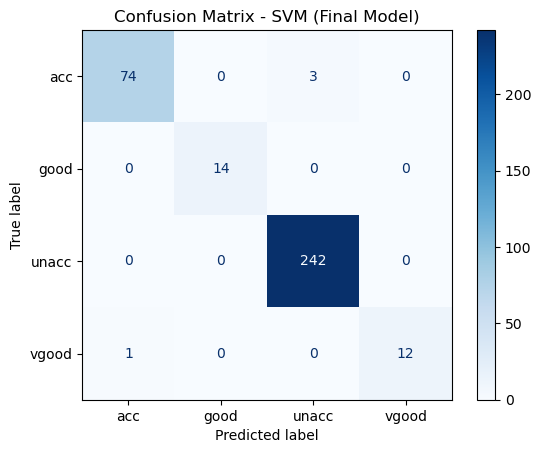

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred_final)

class_labels = label_encoder.classes_  # Ensure this matches your encoded labels

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - SVM (Final Model)")
plt.show()

# Per-Class Performance


Final Model Performance Metrics Per Class:
              precision    recall  f1-score     support
acc            0.986667  0.961039  0.973684   77.000000
good           1.000000  1.000000  1.000000   14.000000
unacc          0.987755  1.000000  0.993840  242.000000
vgood          1.000000  0.923077  0.960000   13.000000
accuracy       0.988439  0.988439  0.988439    0.988439
macro avg      0.993605  0.971029  0.981881  346.000000
weighted avg   0.988468  0.988439  0.988332  346.000000


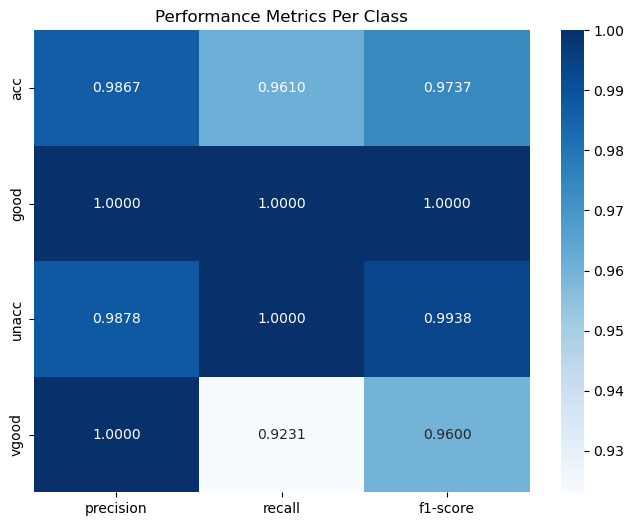

In [20]:
class_report = classification_report(y_test, y_pred_final, target_names=label_encoder.classes_, output_dict=True)

final_metrics_per_class = pd.DataFrame(class_report).T

print("\nFinal Model Performance Metrics Per Class:")
print(final_metrics_per_class)

plt.figure(figsize=(8, 6))
sns.heatmap(final_metrics_per_class.iloc[:-3, :-1], annot=True, cmap="Blues", fmt=".4f")
plt.title("Performance Metrics Per Class")
plt.show()